## 5. Решение квантового основного уравнения для случая одновременных притока и утечки фотонов из оптической полости

<b>Задача.</b>
<em>Рассчитать динамику для фотонов в оптической полости. Есть приток фотонов с коэффициентом $\gamma_{+}$, есть отток с коэффициентом $\gamma_{-}$.
    
- Исследовать динамику при разных $\gamma$, при каких значениях этих параметров произойдет стабилизация матрицы плотности?

- Решить эту же задачу для одного атома в полости.

</em>

### 1. Оптическая полость с фотонами, без атома.

Гамильтониан в случае отсутствия атомов особенно прост:

$$H = \hbar \omega a^\dagger a$$

Очевидно, что диагональные матричные элементы $H$ будут просто равны числу фотонов в базисном состоянии. Выпишем аналитические формулы для матричных элементов $A_+ = a^\dagger$ и $A_- = a$:

$$<n|a^\dagger|n'> = \sqrt{n} \delta_{n,n'+1}$$

$$<n|a|n'> = \sqrt{n+1} \delta_{n,n'-1}$$

In [1]:
from math import *
import numpy as np
import numpy.linalg as linalg
import matplotlib.pyplot as plt

def kron_delta(i,j):
    if i == j:
        return 1
    else:
        return 0

In [2]:
def runge_kutta_4(t,dim,fun,rho_0):

    npoints = len(t)
    rho_list = np.zeros((npoints, dim, dim), dtype=np.cdouble)
    rho = np.array(rho_0,dtype=np.cdouble)
    rho_list[0,:,:] = rho
    
    for i in range(1,npoints):

        h = t[i] - t[i-1]

        # Runge-Kutta
        k1 = fun(rho)
        k2 = fun(rho + 0.5*h*k1)
        k3 = fun(rho + 0.5*h*k2)
        k4 = fun(rho + h*k3)
        rho = rho + 1.0/6.0 * h * (k1 + 2*k2 + 2*k3 + k4)

        rho_list[i,:,:] = rho
    
    return rho_list

def plot_density_diagonal(t, rho_list, basis_labels, nprint):
    dim = rho_list[0].shape[0]
    for i in range(0,nprint+1):
        plt.plot(t, abs(rho_list[:,i,i]), label=basis_labels[i])
    plt.legend(loc='upper right')
    plt.xlabel('t')
    plt.ylabel('density, n')
    plt.show()

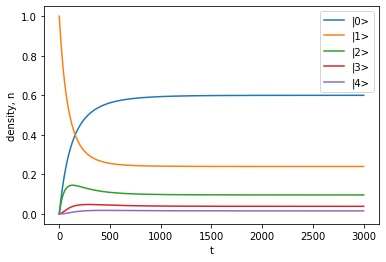

ratio in/out = 0.4000
|n>    rho[n,n]       ratio
  0      0.6000      0.0000
  1      0.2400      0.4000
  2      0.0960      0.4000
  3      0.0384      0.4000
  4      0.0154      0.4000
  5      0.0061      0.4000
  6      0.0025      0.4000
  7      0.0010      0.4000
  8      0.0004      0.4000
  9      0.0002      0.4000
 10      0.0001      0.4000


In [3]:
nmax = 10
basis_dim = nmax + 1
gamma_in = 0.002
gamma_out = 0.005

basis_labels = ['|%d>' % i for i in range(0,nmax+1)]

H = np.zeros((basis_dim,basis_dim))
A_in = np.zeros((basis_dim,basis_dim))
A_out = np.zeros((basis_dim,basis_dim))

for n in range(0,nmax+1):
    for m in range(0,nmax+1):
        H[n,m] = n * kron_delta(n, m)
        A_in[n,m] = sqrt(n) * kron_delta(n,m+1)
        A_out[n,m] = sqrt(n+1) * kron_delta(n,m-1)

def lindblad(gamma, A, rho):
    Aconj = np.transpose(A)
    AconjA = np.matmul(Aconj, A)
    return gamma * (np.matmul(A, np.matmul(rho, Aconj)) - 0.5 * (np.matmul(AconjA, rho) + np.matmul(rho, AconjA)))

def fun_inout_flow(rho):
    L_in = lindblad(gamma_in, A_in, rho)
    L_out = lindblad(gamma_out, A_out, rho)
    return (-1j)*(np.matmul(H, rho) - np.matmul(rho,H)) + L_in + L_out

# initial guess: vacuum state |0>
rho_0 = np.zeros((basis_dim,basis_dim))
rho_0[1,1] = 1

# dynamics
t = np.linspace(0,3000,3001)
rho_list = runge_kutta_4(t, basis_dim, fun_inout_flow, rho_0)

# plot results
plot_density_diagonal(t, rho_list, basis_labels, 4)

print('ratio in/out = %.4f' % (gamma_in/gamma_out))
print('%3s%12s%12s' % ('|n>', 'rho[n,n]', 'ratio'))
for i in range(0,nmax+1):
    rho_ii = abs(rho_list[-1][i,i])
    print('%3d%12.4f%12.4f' % (i, rho_ii, rho_ii/abs(rho_list[-1][i-1,i-1]) if i != 0 else 0))

Получившийся результат означает, что при $t \rightarrow \infty$ достигается соотношение заселенностей базисных состояний

$$\frac{\rho_{nn}}{\rho_{n-1,n-1}} \rightarrow \frac{\gamma_+}{\gamma_-}$$

### 2. Один атом в полости

Теперь повторим численный эксперимент, поместив в полость один атом. Коль скоро система у нас открытая, логично воспользоваться точным гамильтонианом Джейнса-Каммингса. Ограничим базисные состояния наперед заданной энергией $E_{max} = n_{max} \hbar \omega$.

In [4]:
nmax = 2
basis_states = []
for n in range(0,nmax+1):
    for m in range(0,2):
        if n+m <= nmax:
            basis_states.append((n,m))
basis_dim = len(basis_states)
basis_labels = ['|%d,%d>' % (state[0],state[1]) for state in basis_states]
print('basis states:')
for i,state in enumerate(basis_labels):
    print('%3d' % i, state)

basis states:
  0 |0,0>
  1 |0,1>
  2 |1,0>
  3 |1,1>
  4 |2,0>


In [5]:
g = 0.005

H = np.zeros((basis_dim,basis_dim))
A_in = np.zeros((basis_dim,basis_dim))
A_out = np.zeros((basis_dim,basis_dim))

for i,state1 in enumerate(basis_states):
    for j,state2 in enumerate(basis_states):
        n1 = state1[0]
        m1 = state1[1]
        n2 = state2[0]
        m2 = state2[1]
        
        # Hamiltonian matrix elements
        self_photon = n1 * kron_delta(n1,n2) * kron_delta(m1,m2)
        self_atom = kron_delta(m1,1) * kron_delta(n1,n2) * kron_delta(m1,m2)
        int_deexc = g * sqrt(n1) * kron_delta(n1,n2+1) * kron_delta(m1,0) * kron_delta(m2,1)
        int_exc = g * sqrt(n1+1) * kron_delta(n1,n2-1) * kron_delta(m1,1) * kron_delta(m2,0)
        v1 = g * sqrt(n1+1) * kron_delta(n1,n2-1) * kron_delta(m1,0) * kron_delta(m2,1)
        v2 = g * sqrt(n1) * kron_delta(n1,n2+1) * kron_delta(m1,1) * kron_delta(m2,0)
        H[i,j] = self_photon + self_atom + int_deexc + int_exc + v1 + v2
        
        # Annihilation operator (a) matrix elements
        A_in[i,j] = sqrt(n1) * kron_delta(n1,n2+1) * kron_delta(m1,m2)
        
        # Creation operator (a+) matrix elements
        A_out[i,j] = sqrt(n1+1) * kron_delta(n1,n2-1) * kron_delta(m1,m2)

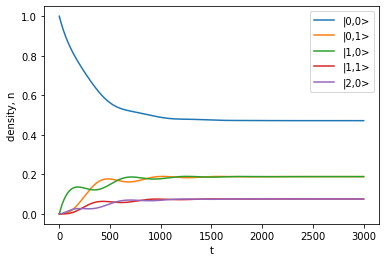

ratio in/out = 0.4000
|n>    rho[n,n]       ratio
| 0 0>       0.4717      0.0000
| 0 1>       0.1886      0.3999
| 1 0>       0.1887      1.0005
| 1 1>       0.0755      0.3999
| 2 0>       0.0755      1.0003


In [6]:
# initial guess: vacuum state |0>
rho_0 = np.zeros((basis_dim,basis_dim))
rho_0[0,0] = 1

# dynamics
t = np.linspace(0,3000,10001)
rho_list = runge_kutta_4(t, basis_dim, fun_inout_flow, rho_0)

# plot results
plot_density_diagonal(t, rho_list, basis_labels, nprint=4)

print('ratio in/out = %.4f' % (gamma_in/gamma_out))
print('%3s%12s%12s' % ('|n>', 'rho[n,n]', 'ratio'))
for i in range(0,basis_dim):
    rho_ii = abs(rho_list[-1][i,i])
    print('|%2d%2d> %12.4f%12.4f' % (basis_states[i][0], basis_states[i][1], rho_ii, rho_ii/abs(rho_list[-1][i-1,i-1]) if i != 0 else 0))

### Два атома в полости

Для описания динамики системы с двумя атомами воспользуемся точным гамильтонианом Тависа-Каммингса:

$$H = \hbar \omega a^\dagger a + \hbar \omega (\sigma_1^\dagger \sigma_1 + \sigma_2^\dagger \sigma_2) + g(a^\dagger + a)(\sigma^\dagger_1 + \sigma^\dagger_2 + \sigma_1 + \sigma_2)$$

Базисные функции должны иметь вид $|n,m_1m_2>$.

В ходе вычисления матрицы H нам придется встретиться со следующими матричными элементами:

- $<n,m_1m_2|a^\dagger a|n',m'_1m'_2> = n\ \delta_{nn'}\delta_{m_1m'_1}\delta_{m_2m'_2}$

- $<n,m_1m_2|\sigma_1^\dagger \sigma_1+\sigma_2^\dagger \sigma_2|n',m'_1m'_2> = (m_1+m_2)\ \delta_{nn'}\delta_{m_1m'_1}\delta_{m_2m'_2}$

- $<n,m_1m_2|a^\dagger (\sigma_1+\sigma_2)|n',m'_1m'_2> = <n|a^\dagger|n'><m_1m_2|\sigma_1+\sigma_2|m'_1m'_2>$

- $<n,m_1m_2|a (\sigma^\dagger_1+\sigma^\dagger_2)|n',m'_1m'_2> = <n|a|n'><m_1m_2|\sigma^\dagger_1+\sigma^\dagger_2|m'_1m'_2>$

- $<n,m_1m_2|a^\dagger (\sigma^\dagger_1+\sigma^\dagger_2)|n',m'_1m'_2> = <n|a^\dagger|n'><m_1m_2|\sigma^\dagger_1+\sigma^\dagger_2|m'_1m'_2>$

- $<n,m_1m_2|a (\sigma_1+\sigma_2)|n',m'_1m'_2> = <n|a|n'><m_1m_2|\sigma_1+\sigma_2|m'_1m'_2>$

- $<m_1m_2|\sigma_1|m'_1m'_2> = \delta_{m_2,m'_2} \delta_{m_1,0} \delta_{m'_1,1}$

- $<m_1m_2|\sigma^\dagger_1|m'_1m'_2> = \delta_{m_2,m'_2} \delta_{m_1,1} \delta_{m'_1,0}$

- $<n|a^\dagger|n'> = \sqrt{n}\ \delta_{n,n'+1}$

- $<n|a|n'> = \sqrt{n+1}\ \delta_{n,n'-1}$

In [7]:
# setup basis
def generate_basis_states(e_max):
    basis_states = []
    for n in range(0,e_max+1):
        for m1 in range(0,2):
            for m2 in range(0,2):
                if n+m1+m2 <= e_max:
                    basis_states.append((n,m1,m2))
    return basis_states

n_max = 6
basis_states = generate_basis_states(n_max)
basis_labels = ['|%d,%d%d>' % state for state in basis_states]
basis_dim = len(basis_states)

for label in basis_labels:
    print(label)

|0,00>
|0,01>
|0,10>
|0,11>
|1,00>
|1,01>
|1,10>
|1,11>
|2,00>
|2,01>
|2,10>
|2,11>
|3,00>
|3,01>
|3,10>
|3,11>
|4,00>
|4,01>
|4,10>
|4,11>
|5,00>
|5,01>
|5,10>
|6,00>


In [8]:
# construct Hamiltonian and A+, A matrices
delta = kron_delta

H = np.zeros((basis_dim, basis_dim))
for i,state1 in enumerate(basis_states):
    for j,state2 in enumerate(basis_states):
        n_1, m1_1, m2_1 = state1
        n_2, m1_2, m2_2 = state2

        # diagonal:
        H[i,j] = (n_1 + m1_1 + m2_1) * delta(n_1,n_2) * delta(m1_1,m1_2) * delta(m2_1,m2_2)
        
        # off-diagonal:
        
        # a+ sigma1
        H[i,j] += g * sqrt(n_1) * delta(n_1,n_2+1) * delta(m2_1,m2_2) * delta(m1_1,0) * delta(m1_2,1)
        # a+ sigma2
        H[i,j] += g * sqrt(n_1) * delta(n_1,n_2+1) * delta(m1_1,m1_2) * delta(m2_1,0) * delta(m2_2,1)
        # a+ sigma1+
        H[i,j] += g * sqrt(n_1) * delta(n_1,n_2+1) * delta(m2_1,m2_2) * delta(m1_1,1) * delta(m1_2,0)
        # a+ sigma2+
        H[i,j] += g * sqrt(n_1) * delta(n_1,n_2+1) * delta(m1_1,m1_2) * delta(m2_1,1) * delta(m2_2,0)

        # a sigma1
        H[i,j] += g * sqrt(n_1+1) * delta(n_1,n_2-1) * delta(m2_1,m2_2) * delta(m1_1,0) * delta(m1_2,1)
        # a sigma2
        H[i,j] += g * sqrt(n_1+1) * delta(n_1,n_2-1) * delta(m1_1,m1_2) * delta(m2_1,0) * delta(m2_2,1)
        # a sigma1+
        H[i,j] += g * sqrt(n_1+1) * delta(n_1,n_2-1) * delta(m2_1,m2_2) * delta(m1_1,1) * delta(m1_2,0)
        # a sigma2+
        H[i,j] += g * sqrt(n_1+1) * delta(n_1,n_2-1) * delta(m1_1,m1_2) * delta(m2_1,1) * delta(m2_2,0)

A_in = np.zeros((basis_dim, basis_dim))
A_out = np.zeros((basis_dim, basis_dim))
for i,state1 in enumerate(basis_states):
    for j,state2 in enumerate(basis_states):
        n_1, m1_1, m2_1 = state1
        n_2, m1_2, m2_2 = state2
        A_in[i,j] = sqrt(n_1) * delta(n_1,n_2+1) * delta(m1_1, m1_2) * delta(m2_1, m2_2)
        A_out[i,j] = sqrt(n_1+1) * delta(n_1,n_2-1) * delta(m1_1, m1_2) * delta(m2_1, m2_2)

В качестве начального состояния возьмем:

$$ \frac{1}{\sqrt{3}} (|0,00>+|0,01>-|0,10>) $$

In [9]:
rho_0 = np.zeros((basis_dim,basis_dim))

#actual order of basis states: |0,00>, |0,01>, |0,10>

rho_0[0,0] = +1/3.
rho_0[1,1] = +1/3.
rho_0[2,2] = +1/3.

rho_0[0,1] = +1/3.
rho_0[0,2] = -1/3.
rho_0[1,2] = -1/3.

rho_0[1,0] = +1/3.
rho_0[2,0] = -1/3.
rho_0[2,1] = -1/3.

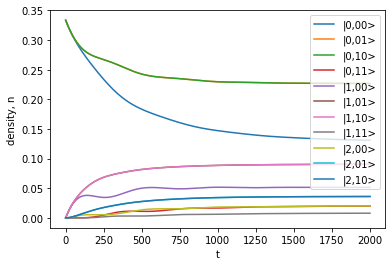

ratio in/out = 0.4000
|n>    rho[n,n]       ratio
|0,00>       0.1310      0.0000
|0,01>       0.2267      1.7302
|0,10>       0.2267      1.0000
|0,11>       0.0200      0.0884
|1,00>       0.0515      2.5680
|1,01>       0.0905      1.7581
|1,10>       0.0905      1.0000
|1,11>       0.0080      0.0880
|2,00>       0.0202      2.5414
|2,01>       0.0361      1.7849
|2,10>       0.0361      1.0000
|2,11>       0.0032      0.0876
|3,00>       0.0080      2.5255
|3,01>       0.0144      1.8060
|3,10>       0.0144      1.0000
|3,11>       0.0013      0.0872
|4,00>       0.0032      2.5157
|4,01>       0.0058      1.8218
|4,10>       0.0058      1.0000
|4,11>       0.0005      0.0869
|5,00>       0.0013      2.5074
|5,01>       0.0023      1.8335
|5,10>       0.0023      1.0000
|6,00>       0.0005      0.2173


In [10]:
# dynamics
t = np.linspace(0,2000,10001)
rho_list = runge_kutta_4(t, basis_dim, fun_inout_flow, rho_0)

# plot results
plot_density_diagonal(t, rho_list, basis_labels, nprint=10)

print('ratio in/out = %.4f' % (gamma_in/gamma_out))
print('%3s%12s%12s' % ('|n>', 'rho[n,n]', 'ratio'))
for i in range(0,basis_dim):
    rho_ii = abs(rho_list[-1][i,i])
    print('%s %12.4f%12.4f' % (basis_labels[i], rho_ii, rho_ii/abs(rho_list[-1][i-1,i-1]) if i != 0 else 0))